In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
import math
import time
from heateq import Exact, Simulateur

In [2]:
seed = 213731490053398181466621250222036675538
rng = Generator(PCG64(seed))

In [3]:
# Espérance exacte de la solution continue
mu_exact = Exact().mu
print(mu_exact)

41.98447216482205


In [4]:
f = Simulateur(21, 100)
g = Simulateur(3, 20)

In [5]:
def n_echantillon_X(n):
    return np.vstack(
        (
            rng.uniform(-math.pi, math.pi, (3, n)),
            rng.uniform(0.001, 0.009, (1, n)), 
            rng.uniform(-1., 1., (3, n))
        )
    )

In [6]:
def rmse_estim(estimations, statistique_exacte):
    return math.sqrt(np.mean((estimations - statistique_exacte)**2))

def std_estim(estimations):
    return np.std(estimations, ddof=1)

def esperance_estim(estimations):
    return np.mean(estimations)

In [7]:
def plot_fig_hf_vs_bf(n_samples, esp_mean_hf, std_mean_hf, rmse_mean_hf, esp_mean_bf, std_mean_bf, rmse_mean_bf, mu_exact, fr=True, eq_cost=False, savefig=None):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))
    eb_hf = axs[0].errorbar(
        n_samples, esp_mean_hf, std_mean_hf,
        fmt='x', color='gray', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Monte Carlo'
    )
    eb_bf = axs[0].errorbar(
        n_samples, esp_mean_bf, std_mean_bf,
        fmt='xb', lw=2, capsize=8, markeredgewidth=2, markersize=7,
        label='Control variate'
    )
    hl = axs[0].axhline(y=mu_exact, linestyle="--", dashes=(3, 3), linewidth=1, color="red", dash_capstyle="round")
    axs[0].set_xscale('log')
    axs[0].set_ylim([-20,100])
    axs[0].set_xlabel( ("budget" if eq_cost else "taille de l'échantillon") if fr else ("budget" if eq_cost else "sample size") )
    axs[0].set_ylabel("estimateurs (moyenne ± ecart-type)" if fr else "estimators (mean ± std)")

    axs[1].plot(n_samples, rmse_mean_hf, 'o-', color='gray', lw=3, markeredgewidth=2, markersize=6, label='Monte Carlo HF')
    axs[1].plot(n_samples, rmse_mean_bf, 'ob-', lw=3, markeredgewidth=2, markersize=6, label='Monte Carlo BF')
    axs[1].set_xscale('log')
    axs[1].set_yscale('log')
    axs[1].set_xlabel( ("budget" if eq_cost else "taille de l'échantillon") if fr else ("budget" if eq_cost else "sample size") )
    axs[1].set_ylabel("REQM des estimateurs" if fr else "RMSE of the estimators")
    axs[1].legend()

    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight', pad_inches=0.02)


In [8]:
# Espérance exacte de Y = f(X) (solution discrétisée, haute fidélité)
mu_Y_exact = f.mu

# Espérance exacte de Z = g(X) (solution discrétisée, basse fidélité)
mu_Z_exact = g.mu

print(mu_Y_exact, mu_Z_exact)

41.916465294707976 33.03617206344313


In [9]:
print(mu_Y_exact - mu_exact)
print(mu_Z_exact - mu_exact)

-0.06800687011407547
-8.94830010137892


In [10]:
ns = 1000000
X = n_echantillon_X(ns)

st = time.process_time()
Y = f(X)
et = time.process_time()
time_f = et - st

st = time.process_time()
Z = g(X)
et = time.process_time()
time_g = et - st

w = time_g / time_f

print(time_f, time_g)
print(w, 1/35)

22.629125577 0.5429357809999971
0.0239927866038196 0.02857142857142857


In [11]:
w = 1./35.

In [12]:
nr = 1000
n_samples = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
esp_Y_mean  = []
std_Y_mean  = []
rmse_Y_mean = []
esp_Z_mean  = []
std_Z_mean  = []
rmse_Z_mean = []
esp_Z_mean_eq_cost  = []
std_Z_mean_eq_cost  = []
rmse_Z_mean_eq_cost = []
for ns in n_samples:
    ns_eq_cost = int(ns / w)
    Y_mean = np.zeros(nr)
    Z_mean = np.zeros(nr)
    Z_mean_eq_cost = np.zeros(nr)
    for ir in range(nr):
        X = n_echantillon_X(ns)
        X_eq_cost = n_echantillon_X(ns_eq_cost)
        Y = f(X)
        Z = g(X)
        Z_eq_cost = g(X_eq_cost)
        Y_mean[ir] = np.mean(Y)
        Z_mean[ir] = np.mean(Z)
        Z_mean_eq_cost[ir] = np.mean(Z_eq_cost)
    
    esp_Y_mean  += [esperance_estim(Y_mean)]
    std_Y_mean  += [std_estim(Y_mean)]
    rmse_Y_mean += [rmse_estim(Y_mean, mu_exact)]
    
    esp_Z_mean  += [esperance_estim(Z_mean)]
    std_Z_mean  += [std_estim(Z_mean)]
    rmse_Z_mean += [rmse_estim(Z_mean, mu_exact)]

    esp_Z_mean_eq_cost  += [esperance_estim(Z_mean_eq_cost)]
    std_Z_mean_eq_cost  += [std_estim(Z_mean_eq_cost)]
    rmse_Z_mean_eq_cost += [rmse_estim(Z_mean_eq_cost, mu_exact)]
    
    print("HF", ns, ns,
          np.mean(Y_mean), rmse_estim(Y_mean, mu_exact), std_estim(Y_mean)
         )
    print("BF", ns, ns_eq_cost,
          np.mean(Z_mean), rmse_estim(Z_mean, mu_exact), std_estim(Z_mean),           
          np.mean(Z_mean_eq_cost), rmse_estim(Z_mean_eq_cost, mu_exact), std_estim(Z_mean_eq_cost)
         )
    print()

HF 5 5 42.41932982303291 47.89517922315735 47.91716964494294
BF 5 175 33.398839158980685 47.93085721811727 47.17923122955655 32.78249972695185 12.120121908736078 7.891979579102965

HF 10 10 43.744891992164526 34.12776693456712 34.09938659474346
BF 10 350 34.815813857693975 34.447011811430684 33.70969154585378 32.88291881458713 10.61925574944995 5.473598410974078

HF 20 20 41.404638280482 23.408086449501383 23.41261314651249
BF 20 700 32.60057511282241 25.03030960819321 23.21632772581733 32.9247826374409 9.870981023076203 3.9209266367890474

HF 50 50 41.49606001773394 15.158527617875363 15.158238199136754
BF 50 1750 32.6197051632975 17.584511573308532 14.890867140740383 33.04081433446411 9.29012975409852 2.51472051742224

HF 100 100 41.37000404888218 10.872442312005777 10.860496358064411
BF 100 3500 32.45956977749116 14.411037321552781 10.819949283499575 33.073484928772615 9.086186851332522 1.7765849910777156

HF 200 200 41.745513832916856 7.350818432812345 7.350609635247721
BF 200 7000

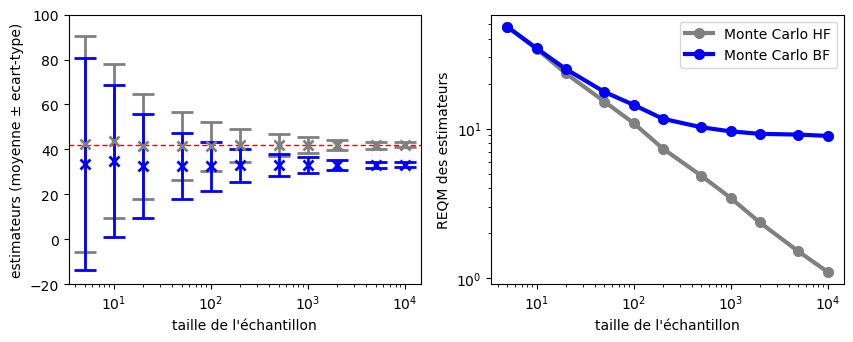

In [ ]:
plot_fig_hf_vs_bf(n_samples, esp_Y_mean, std_Y_mean, rmse_Y_mean, esp_Z_mean, std_Z_mean, rmse_Z_mean, mu_exact, fr=True)

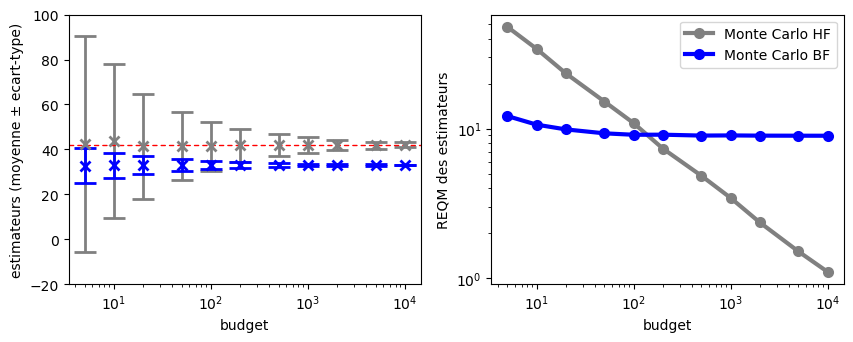

In [ ]:
plot_fig_hf_vs_bf(n_samples, esp_Y_mean, std_Y_mean, rmse_Y_mean, esp_Z_mean_eq_cost, std_Z_mean_eq_cost, rmse_Z_mean_eq_cost, mu_exact, fr=True, eq_cost=True)